# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.20 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from collections import deque, namedtuple
import random
import copy
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [7]:
# Hyperparameter
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-3              # for soft update of target parameters
LR_ACTOR = 5e-4         # learning rate of the actor
LR_CRITIC = 5e-4         # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 3
NOISE_DECAY = 0.99
BEGIN_TRAINING_AT = 500
NOISE_START = 1.0
NOISE_END = 0.1


In [8]:
 # help function for init the weight
def fanin_init(size, fanin=None): 
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).uniform_(-v, v)

class Actor(nn.Module):
    def __init__(self, nb_states, nb_actions, hidden1=256, hidden2=128, init_w=3e-3):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(nb_states, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, nb_actions)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.init_weights(init_w)
    
    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-init_w, init_w)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.tanh(out)
        return out

class Critic(nn.Module):
    def __init__(self, nb_states, nb_actions, hidden1=256, hidden2=128, init_w=3e-3):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(nb_states, hidden1)
        self.fc2 = nn.Linear(hidden1+nb_actions, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.relu = nn.ReLU()
        self.init_weights(init_w)
    
    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-init_w, init_w)
    
    def forward(self, state, action):
        out = self.fc1(state)
        out = self.relu(out)
        out = self.fc2(torch.cat([out,action],1))
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [9]:
# add nosie to the sample
class RandomNoise:
    """Random noise process."""
    def __init__(self, size, weight, min_weight, noise_decay,begin_noise_at, seed):
        self.size = size
        self.weight_start = weight
        self.weight = weight
        self.min_weight = min_weight
        self.noise_decay = noise_decay
        self.begin_noise_at = begin_noise_at
        self.seed = random.seed(seed)

    def reset(self):
        self.weight = self.weight_start

    def sample(self, i_episode):
        pwr = max(0, i_episode - self.begin_noise_at)
        if pwr > 0:
            self.weight = max(self.min_weight, self.noise_decay**pwr)
        return self.weight * 0.5 * np.random.standard_normal(self.size)

In [10]:
# save the replay and learn for the replay buffer
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.stack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.stack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.stack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [11]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, index, nb_agents, random_seed):

        self.state_size = state_size
        self.action_size = action_size
        self.index = torch.tensor([index]).to(device)
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(nb_agents*state_size, nb_agents*action_size, random_seed).to(device)
        self.critic_target = Critic(nb_agents*state_size, nb_agents*action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = RandomNoise(self.action_size,NOISE_START, NOISE_END, NOISE_DECAY,BEGIN_TRAINING_AT, random_seed)

    def act(self, state, i_episode = 0, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample(i_episode)
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, actions_target, actions_pred):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        rewards = rewards.unsqueeze(-1)
        dones = dones.unsqueeze(-1)

        # ---------------------------- update critic ----------------------------
        actions_target = torch.cat(actions_target, dim=1).to(device)
        
        Q_targets_next = self.critic_target(next_states.reshape(next_states.shape[0], -1), actions_target.reshape(next_states.shape[0], -1))
        # Compute Q targets for current states (y_i)
        Q_targets = rewards.index_select(1, self.index).squeeze(1) + (gamma * Q_targets_next * (1 - dones.index_select(1, self.index).squeeze(1)))
        # Compute critic loss
        Q_expected = self.critic_local(states.reshape(states.shape[0], -1), actions.reshape(actions.shape[0], -1))

        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        actions_pred = torch.cat(actions_pred, dim=1).to(device)
        
        actor_loss = -self.critic_local(states.reshape(states.shape[0], -1), actions_pred.reshape(actions_pred.shape[0], -1)).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()                      

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [12]:
class MultiAgents():
    def __init__(self, state_size, action_size, n_agents, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.t_step = 0
        self.seed = random.seed(random_seed)
        
        self.multiagents = [Agent(state_size, action_size, i, n_agents, random_seed) for i in range(n_agents)]
        
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.memory.add(states, actions, rewards, next_states, dones)
            
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if len(self.memory) > BATCH_SIZE and self.t_step == 0:
            for _ in range(3):
                for agent in self.multiagents:
                    experiences = self.memory.sample()
                    self.learn(experiences, agent, GAMMA)
                    
                for agent in self.multiagents:
                    agent.soft_update(agent.critic_local,agent.critic_target,TAU)
                    agent.soft_update(agent.actor_local,agent.actor_target,TAU)   
    def learn(self, experiences, agent, gamma):
        states, actions, _, _, _ = experiences

        actions_target =[agent_j.actor_target(states.index_select(1, torch.tensor([j]).to(device)).squeeze(1)) for j, agent_j in enumerate(self.multiagents)]
        
        agent_action_pred = agent.actor_local(states.index_select(1, agent.index).squeeze(1))
        actions_pred = [agent_action_pred if j==agent.index.cpu().numpy()[0] else actions.index_select(1, torch.tensor([j]).to(device)).squeeze(1) for j, agent_j in enumerate(self.multiagents)]
        
        agent.learn(experiences,gamma,actions_target,actions_pred) 
        
    def act(self, states,n_episode, add_noise=True):
        actions = [np.squeeze(agent.act(np.expand_dims(state, axis=0), n_episode, add_noise), axis=0) for agent, state in zip(self.multiagents, states)]
        return np.stack(actions)
    def reset(self):
        for agent in self.multiagents:
            agent.reset()

In [19]:
def train_maddpg(n_episodes=10000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        ma.reset()
        score = np.zeros(num_agents)
        while True:
            actions = ma.act(states, i_episode)
            env_info = env.step(actions)[brain_name] 
            next_states =  env_info.vector_observations
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            ma.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if any(dones):
                break 
        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")    
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - print_every, np.mean(scores_deque)))
            for i, agent in enumerate(ma.multiagents):
                torch.save(agent.actor_local.state_dict(), f'checkpoint_actor_{i}.pth')
                torch.save(agent.critic_local.state_dict(), f'checkpoint_critic_{i}.pth')            
            break
            
    return scores

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ma = MultiAgents(state_size, action_size, n_agents=num_agents, random_seed=21)

In [21]:
scores = train_maddpg()


Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.02
Episode 500	Average Score: 0.01
Episode 600	Average Score: 0.01
Episode 700	Average Score: 0.02
Episode 800	Average Score: 0.00
Episode 900	Average Score: 0.02
Episode 1000	Average Score: 0.05
Episode 1100	Average Score: 0.07
Episode 1200	Average Score: 0.06
Episode 1300	Average Score: 0.04
Episode 1400	Average Score: 0.06
Episode 1500	Average Score: 0.05
Episode 1600	Average Score: 0.06
Episode 1700	Average Score: 0.07
Episode 1800	Average Score: 0.07
Episode 1900	Average Score: 0.08
Episode 2000	Average Score: 0.10
Episode 2100	Average Score: 0.18
Episode 2200	Average Score: 0.30
Episode 2300	Average Score: 0.35
Episode 2400	Average Score: 0.28
Episode 2453	Average Score: 0.50
Environment solved in 2353 episodes!	Average Score: 0.50


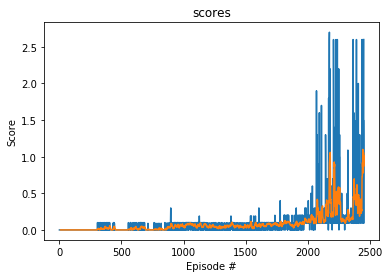

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(f'scores')
rolling_mean = pd.Series(scores).rolling(10).mean()
plt.plot(rolling_mean);